In [1]:
from models import DenseMCDropoutNetwork, BayesianDenseNetwork, BNN
#from query_strategies import random_sampling, query_by_comitee, emoc
from models.losses import tobit_nll
#from datasets import get_dataset
from read_data import *
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import copy
tfd = tfp.distributions
import pandas
import torch

/home/fbohy/censored_active_learning/AL/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x_train, y_train, censoring_train, x_test, y_test = get_dataset("whas")

NameError: name 'censoring_train' is not defined

(0.0, 200.0)

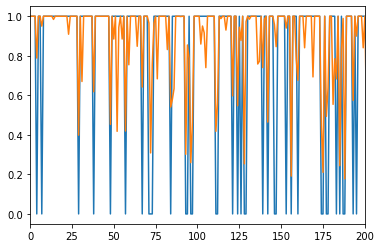

In [11]:
plt.plot(censoring_train)
plt.plot(y_train/max(y_train))
plt.xlim(0,200)

In [22]:
means = np.mean(x_train, axis=0)
stds = np.std(x_train, axis=0)

In [25]:
np.std((x_train-means)/stds

array([1.000009  , 1.0000048 , 0.99999696, 1.0000011 , 1.0000006 ,
       0.9999973 , 1.0000013 ], dtype=float32)

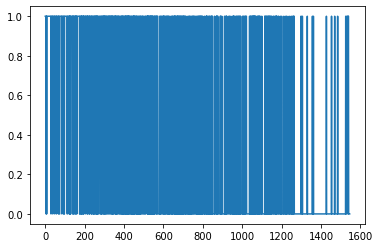

In [6]:
plt.plot(censoring_train)

In [67]:
import sklearn

In [68]:
data = sklearn.datasets.fetch_california_housing()

In [69]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

(array([ 877., 3612., 4099., 3771., 2799., 1769., 1239.,  752.,  479.,
        1243.]),
 array([0.14999 , 0.634992, 1.119994, 1.604996, 2.089998, 2.575   ,
        3.060002, 3.545004, 4.030006, 4.515008, 5.00001 ]),
 <BarContainer object of 10 artists>)

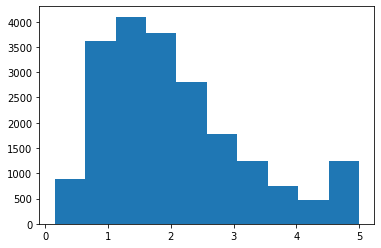

In [70]:
plt.hist(data['target'])

In [101]:
x = np.random.uniform(low =0, high=2, size=200)
y = x*np.sin(2*x)+10+np.random.normal(loc=0, scale=(0.5*x+0.5)**2)
cen = 2*x+10+np.random.normal(loc=0, scale=2**2, size=200)
#y = np.exp(2*x+4)
#cen = np.exp(-3*x+15)

In [102]:
sum(y > cen)/200

0.33

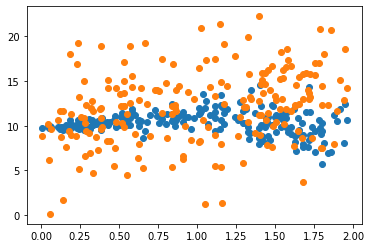

In [103]:
plt.plot(x,y,'o')
plt.plot(x,cen,'o')

In [2]:
dataset = "sklearn"
x_train, y_train, censoring_train, x_test, y_test = get_dataset(dataset)

11000
(1000,)
(10000, 6)
(10000,)
(10000,)
(1000, 6)
(1000,)


(array([ 994., 1013.,  986.,  962., 1047., 1009., 1006.,  971., 1006.,
        1006.]),
 array([1.75667294e-06, 9.99987727e-02, 1.99995789e-01, 2.99992805e-01,
        3.99989821e-01, 4.99986837e-01, 5.99983853e-01, 6.99980869e-01,
        7.99977885e-01, 8.99974901e-01, 9.99971917e-01]),
 <BarContainer object of 10 artists>)

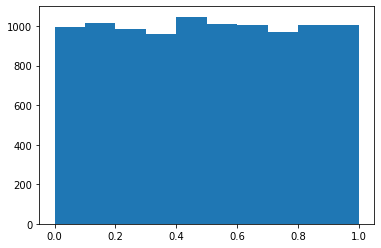

In [7]:
plt.hist(x_train[:,0])

(array([1045., 1003., 1000.,  997., 1001., 1008., 1035.,  950.,  985.,
         976.]),
 array([1.53386650e-04, 1.00135139e-01, 2.00116890e-01, 3.00098642e-01,
        4.00080394e-01, 5.00062146e-01, 6.00043898e-01, 7.00025650e-01,
        8.00007401e-01, 8.99989153e-01, 9.99970905e-01]),
 <BarContainer object of 10 artists>)

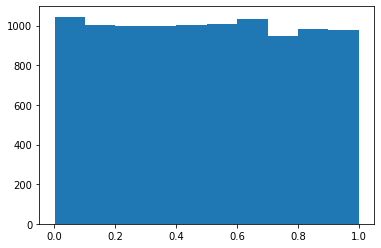

In [8]:
plt.hist(x_train[:,1])

In [3]:
# Do not use GPU
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
"""Data is generated as follows:
- Define latent function f(x) = 2 + 0.5*sin(2x) + x/10
- Generetae observations from the latent function y_obs (assuming some small observation noise, let's focus on censoring)
- Select the points in the oscillation peaks. 
- Apply a p_c% manual censoring to those points sampled uniformly between [0.2, 0.3] for all selected points.
"""

np.random.seed(10)
n = 250
# Define underlying function
x = np.linspace(0, 10, n)
#x = np.sort(np.concatenate((x,np.linspace(0,2, n))))
#x = x[(x < 3.2) | (x > 5.2)]
y_true = 0.5*np.sin(2*x) + 2 #+ x/10
#y_true = 0.5*x + 2

# Generate noisy observations 
y_obs = y_true + np.random.normal(loc=0, scale=0.005*x, size=x.shape[0]) ## Heterogenue noise
#y_obs = y_true + np.random.normal(loc=0, scale=0.01, size=x.shape[0]) ## Homo noise
y_cens = copy.deepcopy(y_obs)
#x_true = np.linspace(0,10,n)
#y_true = 0.5*np.sin(2*x_true) + 2 #+ x/10
# Select random points as censored and apply p% censoring
#censoring = np.int32(0.5*np.sin(2*x) + 2 >= 2) 
cens_levl = 2.2
censoring = np.int32(0.5*np.sin(2*x) + 2 >cens_levl) 
#censoring = np.random.choice(2, n, p=[0.1, 0.9])*censoring # this can be used to uncensor some.
p_c = np.random.uniform(low=0.10, high=0.30, size=np.sum(censoring==1))
#y_cens[censoring == 1] = y_obs[censoring == 1]*(1-p_c)
y_cens[censoring == 1] = cens_levl + np.random.normal(loc=0, scale=0.05, size=sum(censoring))

In [5]:
x = x.reshape(len(x),1)
y_cens = y_cens.reshape(len(x),1)
#censoring = censoring.reshape(n,1)

In [6]:
test_ids = np.random.choice(np.arange(0,n), size=int(n*0.2), replace=False)

In [7]:
#test_ids = np.random.choice(np.arange(0,n), size=int(n*0.2), replace=False)
#x_train = x[~np.isin(np.arange(len(x)), test_ids)]
#y_train = y_cens[~np.isin(np.arange(len(x)), test_ids)]
#x_test = x[test_ids]
#y_test = y_true[test_ids]

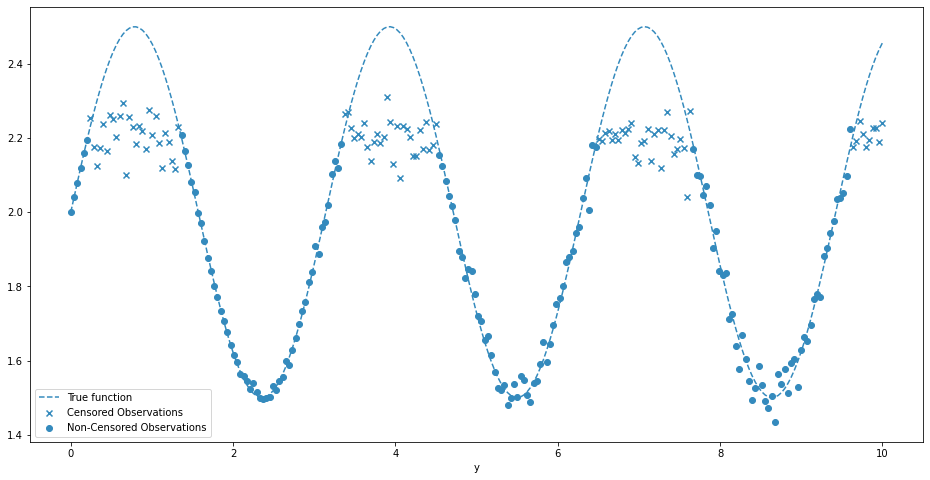

In [8]:
plt.figure(figsize=(16,8))
plt.plot(x, y_true, linestyle="--", label="True function", color='#348ABD')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');
plt.xlabel("x")
plt.xlabel("y")
plt.legend()

In [9]:
tmp = np.concatenate((y_cens, censoring[:,np.newaxis]), axis=1)

In [10]:
tmp = torch.tensor(tmp).float()
x_train = torch.tensor(x).float()

In [11]:
model = BNN.BayesianNN(x_train.shape[-1],0,0)

In [12]:
model

BayesianNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc1_drop): ConsistentMCDropout(p=0.2)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc2_drop): ConsistentMCDropout(p=0.2)
  (fc3_drop): ConsistentMCDropout(p=0.2)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=4, bias=True)
)

In [21]:
def combined_tobit(y, f):
    """ loss function for Tobit likelihood

    y_true: true regression labels
    yhat: estimated labels, in a TF distribution
    censored: a binary list where 1 is a censored observations
    """
    y_pred = f[:,0]
    softplus = torch.nn.Softplus()
    sigma = 1e-5 + softplus(f[:,1])
    y_true = y[:,0]#tf.cast(y[:,0], tf.float32)
    censored = y[:,1].int().bool() #tf.cast(y[:,1], tf.float32)
    norm = torch.distributions.Normal(loc=0., scale=1.)
    
    loglik_not_cens_arg = norm.log_prob((y_pred-y_true)/sigma).exp() / sigma
    loglik_cens_arg = 1. - norm.cdf((y_true-y_pred)/sigma)

    loglik_not_cens_arg = torch.clip(loglik_not_cens_arg, 0.0000001, 10000000)
    loglik_cens_arg = torch.clip(loglik_cens_arg, 0.0000001, 10000000)

    loglik =  torch.where(censored,  torch.log(loglik_cens_arg),  torch.log(loglik_not_cens_arg))
    
    negloglik = -1*(loglik.sum())
    return negloglik

def nll(y, f):
    """ loss function for Tobit likelihood

    y_true: true regression labels
    yhat: estimated labels, in a TF distribution
    censored: a binary list where 1 is a censored observations
    """
    y_pred = f[:,0]
    softplus = torch.nn.Softplus()
    sigma = 1e-5 + softplus(f[:,1])
    y_true =y[:,0] #tf.cast(y[:,0], tf.float32)
    #y_pred = #tf.cast(y_pred, tf.float32)
    #sigma = #tf.cast(sigma, tf.float32)
    
    #norm = tfp.distributions.Normal(loc=0., scale=1.)
    norm = torch.distributions.Normal(loc=0., scale=1.)
    loglik_not_cens_arg = norm.log_prob((y_pred-y_true)/sigma).exp() / sigma
    loglik_not_cens_arg = torch.clip(loglik_not_cens_arg, 0.0000001, 10000000)
    negloglik = -1.0*(torch.log(loglik_not_cens_arg).sum())
    return negloglik




def combined_loss(y, f):
    loss = 0.0
    loss += combined_tobit(y, f[:,:2])
    #loss += tf.reduce_mean((y[:,0] - f[:,-1])**2)
    loss += nll(y, f[:,2:])
    #y = tf.cast(y, tf.float32)
    # = tf.cast(f, tf.float32)
    return loss


In [22]:
import torch
from torch.utils.data import DataLoader

dataset = torch.utils.data.TensorDataset(x_train, tmp)

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


In [23]:
# Train
model = BNN.BayesianNN(x_train.shape[-1],0,0, dropout_p=0.05)
epochs = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

for i in range(0,epochs):
    for _, (data, target) in enumerate(train_dataloader):
        model.train()

        data = data#.to(device=device)
        target = target#.to(device=device)
        optimizer.zero_grad()
        prediction = model(data, k=1).squeeze(1)
        #loss = combined_tobit(target, prediction)
        #loss = nll(target, prediction)
        loss = combined_loss(target, prediction)
        print(loss)
        #loss = ((target-prediction)**2).mean()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()



tensor(621.0234, grad_fn=<AddBackward0>)
tensor(334.9586, grad_fn=<AddBackward0>)
tensor(169.1409, grad_fn=<AddBackward0>)
tensor(200.8811, grad_fn=<AddBackward0>)
tensor(281.9485, grad_fn=<AddBackward0>)
tensor(145.7117, grad_fn=<AddBackward0>)
tensor(193.1274, grad_fn=<AddBackward0>)
tensor(300.1360, grad_fn=<AddBackward0>)
tensor(214.0472, grad_fn=<AddBackward0>)
tensor(149.2126, grad_fn=<AddBackward0>)
tensor(179.2185, grad_fn=<AddBackward0>)
tensor(230.7352, grad_fn=<AddBackward0>)
tensor(218.0105, grad_fn=<AddBackward0>)
tensor(161.8989, grad_fn=<AddBackward0>)
tensor(154.9288, grad_fn=<AddBackward0>)
tensor(185.1208, grad_fn=<AddBackward0>)
tensor(211.1887, grad_fn=<AddBackward0>)
tensor(154.7226, grad_fn=<AddBackward0>)
tensor(119.3460, grad_fn=<AddBackward0>)
tensor(179.3076, grad_fn=<AddBackward0>)
tensor(182.8426, grad_fn=<AddBackward0>)
tensor(151.6523, grad_fn=<AddBackward0>)
tensor(103.8277, grad_fn=<AddBackward0>)
tensor(134.3322, grad_fn=<AddBackward0>)
tensor(160.0390,

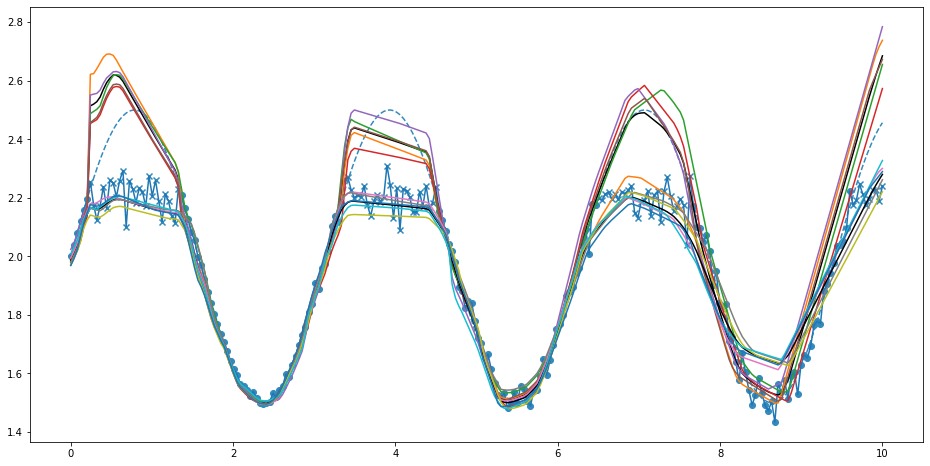

In [24]:
model.eval()
preds = model(x_train, k=5)
plt.figure(figsize=(16,8))

plt.plot(x, y_true, linestyle="--", label="True function", color='#348ABD')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD')
plt.plot(x_train, tmp[:,0].detach())
plt.plot(x_train, preds.mean(1)[:,0].detach(), color = 'black')
plt.plot(x_train, preds[:,0,0].detach())
plt.plot(x_train, preds[:,1,0].detach())
plt.plot(x_train, preds[:,2,0].detach())
plt.plot(x_train, preds[:,3,0].detach())
plt.plot(x_train, preds[:,4,0].detach())
plt.plot(x_train, preds.mean(1)[:,2].detach(), color = 'black')
plt.plot(x_train, preds[:,0,2].detach())
plt.plot(x_train, preds[:,1,2].detach())
plt.plot(x_train, preds[:,2,2].detach())
plt.plot(x_train, preds[:,3,2].detach())
plt.plot(x_train, preds[:,4,2].detach())

In [90]:
preds.mean(1)[:,0]

torch.Size([250])

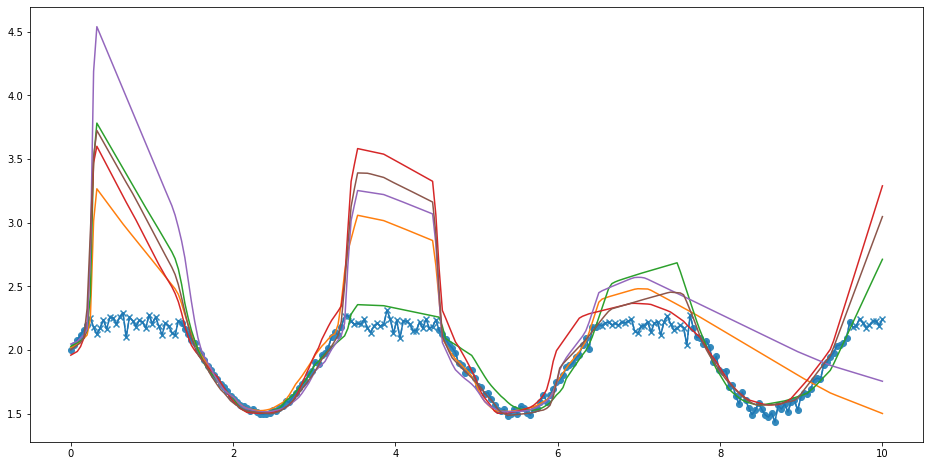

In [78]:
plt.figure(figsize=(16,8))
plt.plot(x, y_true, linestyle="--", label="True function", color='#348ABD')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD')
plt.plot(x_train, tmp[:,0].detach())
plt.plot(x_train, preds[:,0,0].detach())
plt.plot(x_train, preds[:,1,0].detach())
plt.plot(x_train, preds[:,2,0].detach())
plt.plot(x_train, preds[:,3,0].detach())
plt.plot(x_train, preds[:,4,0].detach())

In [56]:
model.eval()
preds = model(x_train, k=1).squeeze(1)

In [65]:
y_pred = preds[:,0]
softplus = torch.nn.Softplus()
sigma = 1e-5 + softplus(preds[:,1])
y_true = tmp[:,0]#tf.cast(y[:,0], tf.float32)
censored = tmp[:,1].int().bool() #tf.cast(y[:,1], tf.float32)
norm = torch.distributions.Normal(loc=0., scale=1.)

loglik_not_cens_arg = norm.log_prob((y_pred-y_true)/sigma).exp() / sigma
#loglik_cens_arg = 1. - norm.cdf((y_true-y_pred)/sigma)

#loglik_not_cens_arg = torch.clip(loglik_not_cens_arg, 0.0000001, 10000000)
#loglik_cens_arg = torch.clip(loglik_cens_arg, 0.0000001, 10000000)

#loglik = (loglik_cens_arg*(1.0-censored))+(torch.log(loglik_cens_arg)*censored)
#loglik = (torch.log(loglik_not_cens_arg)*(1-censored))+(torch.log(loglik_cens_arg)*(censored))
#loglik =  torch.where(censored,  torch.log(loglik_cens_arg),  torch.log(loglik_not_cens_arg))

#negloglik = -1*(loglik.sum())

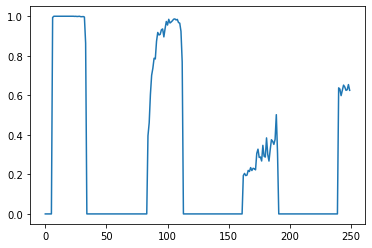

In [70]:
plt.plot(((1. - norm.cdf((y_true-y_pred)/sigma))*tmp[:,1]).detach())

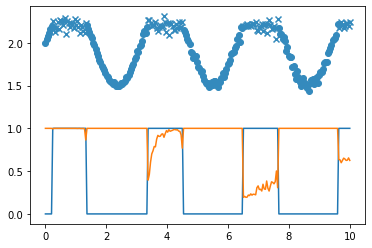

In [64]:
#plt.plot(x_train, (norm.log_prob((y_pred-y_true)/sigma).exp() / sigma).detach())
#plt.plot(x_train, 1. - norm.cdf((y_true-y_pred)/sigma).detach())

#plt.plot(x_train, (norm.log_prob((y_pred-y_true)/sigma).exp() / sigma).detach()*(1-censoring))
#plt.plot(x_train, censoring)
plt.plot(x_train, tmp[:,1])
plt.plot(x_train, (1. - norm.cdf((y_true-y_pred)/sigma)*tmp[:,1]).detach())
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD')

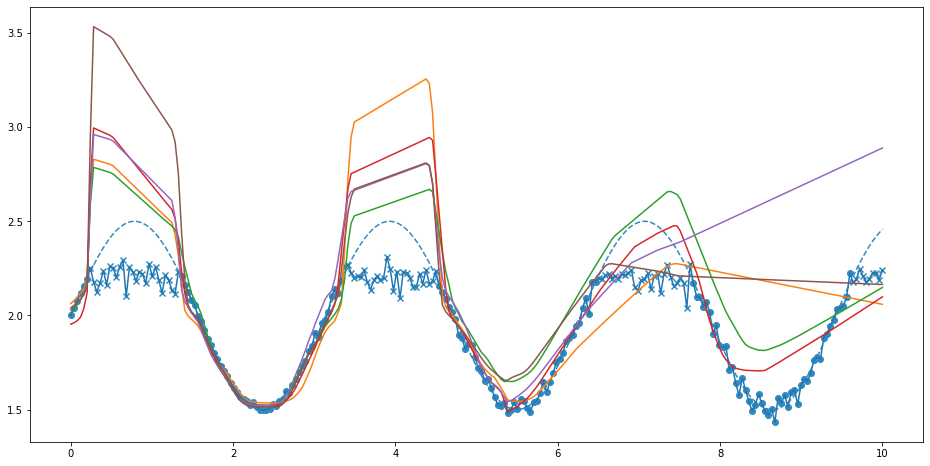

In [25]:
plt.figure(figsize=(16,8))
plt.plot(x, y_true, linestyle="--", label="True function", color='#348ABD')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD')
plt.plot(x_train, tmp[:,0].detach())
plt.plot(x_train, preds[:,0,0].detach())
plt.plot(x_train, preds[:,1,0].detach())
plt.plot(x_train, preds[:,2,0].detach())
plt.plot(x_train, preds[:,3,0].detach())
plt.plot(x_train, preds[:,4,0].detach())

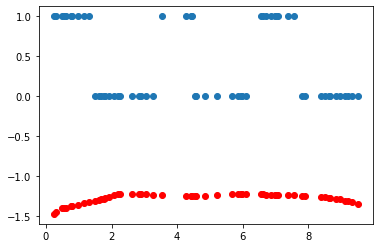

In [135]:
plt.plot(data, target[:,1].detach(),'o')
plt.plot(data, preds[:,1].detach(),'ro')

In [ ]:
#model.compile(loss=[lambda y_true, y_pred: tobit_nll(y_true, y_pred, censoring)],optimizer=opt)
#model.compile(loss=[lambda y_true_, y_pred: tobit_nll(y_true_, y_pred, censoring)],optimizer=opt)
#model.compile(loss=[lambda y_true_, y_pred: tobit_test(y_true_, y_pred)],optimizer=opt)
model.compile(loss=[lambda y_true_, y_pred: combined_loss(y_true_, y_pred)],optimizer=opt)
#model.compile(loss='mae',optimizer=opt)
history = model.fit(x, tmp, epochs = 5000, verbose = 2, shuffle=True)

AttributeError: 'BayesianNN' object has no attribute 'compile'

In [ ]:
ensemble_size = 10
x_ = np.linspace(0,10,250).reshape(250,1)
cens_preds = np.zeros([ensemble_size, x.shape[0]])
uncens_preds = np.zeros([ensemble_size, x.shape[0]])
#stds =  np.zeros([ensemble_size, x.shape[0],1])
for i in range(ensemble_size):
    _ = model(x_)
    cens_preds[i] = _[:,0]
    uncens_preds[i] = _[:,-1]
    #preds[i] =_
    #preds[i] =_.mean()
    #stds[i] = _.stddev()
 

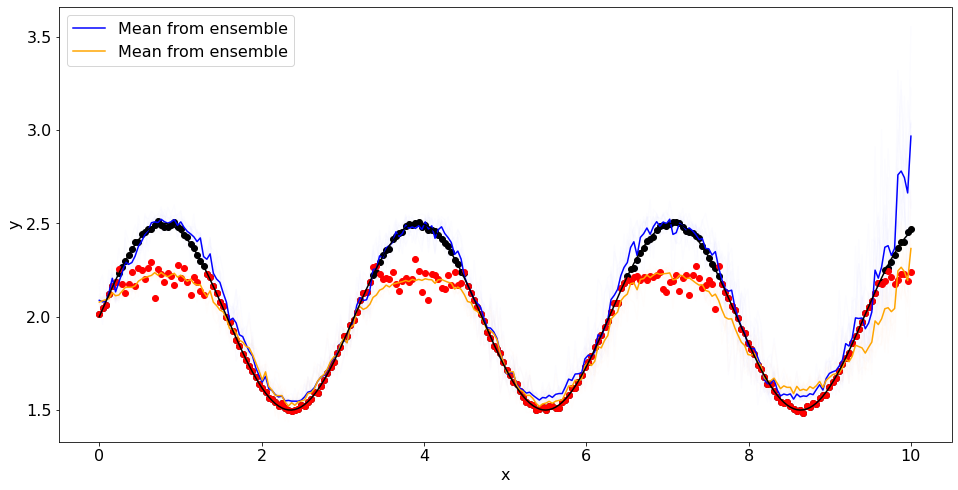

In [ ]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 16})
for i in range(ensemble_size):
    plt.plot(x_, cens_preds[i], color='blue',alpha=0.01)
    plt.plot(x_, uncens_preds[i], color='orange',alpha=0.01)

plt.plot(x_,np.mean(cens_preds, axis=0), label='Mean from ensemble', color='blue')
plt.plot(x_,np.mean(uncens_preds, axis=0), label='Mean from ensemble', color='orange')
#plt.plot(x_, cens, label = 'cens')
#plt.plot(x_,uncens, label='unces')
#plt.plot(x,np.mean(preds, axis=0)-np.std(preds, axis=0))
#plt.plot(x, y_hat)
plt.plot(x, y_true, color='black')
plt.scatter(x, y_obs, color='black')
plt.scatter(x, y_cens, color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.legend()

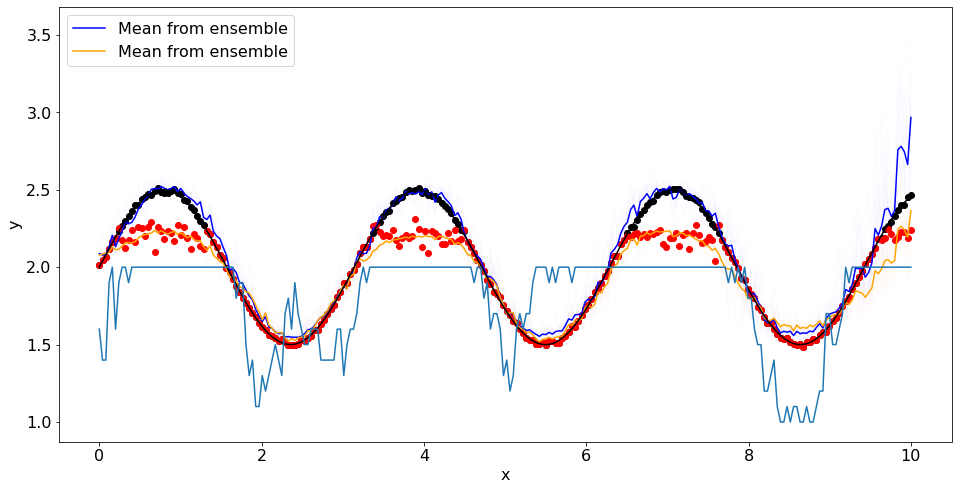

In [ ]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 16})
for i in range(ensemble_size):
    plt.plot(x_, cens_preds[i], color='blue',alpha=0.01)
    plt.plot(x_, uncens_preds[i], color='orange',alpha=0.01)

plt.plot(x_,np.mean(cens_preds, axis=0), label='Mean from ensemble', color='blue')
plt.plot(x_,np.mean(uncens_preds, axis=0), label='Mean from ensemble', color='orange')
#plt.plot(x_, cens, label = 'cens')
#plt.plot(x_,uncens, label='unces')
#plt.plot(x,np.mean(preds, axis=0)-np.std(preds, axis=0))
#plt.plot(x, y_hat)
plt.plot(x, y_true, color='black')
plt.scatter(x, y_obs, color='black')
plt.scatter(x, y_cens, color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.plot(x_, 1+np.mean(cens_preds > uncens_preds, axis = 0))

In [ ]:
from scipy import stats

_eps = 1e-7

def random(mu_0, mu_1, t, pt, temperature):
    return np.ones_like(mu_0.mean(0))


def tau(mu_0, mu_1, t, pt, temperature):
    return (mu_1 - mu_0).var(0) ** (1 / temperature)


def mu(mu_0, mu_1, t, pt, temperature):
    return (t * mu_1.var(0) + (1 - t) * mu_0.var(0)) ** (1 / temperature)


def rho(mu_0, mu_1, t, pt, temperature):
    return tau(mu_0, mu_1, t, pt, temperature) / (
        mu(mu_0, mu_1, 1 - t, pt, temperature) + _eps
    )


def mu_rho(mu_0, mu_1, t, pt, temperature):
    return mu(mu_0, mu_1, t, pt, temperature) * rho(mu_0, mu_1, t, pt, temperature)


def pi(mu_0, mu_1, t, pt, temperature):
    return t * (1 - pt) + (1 - t) * pt


def mu_pi(mu_0, mu_1, t, pt, temperature):
    return mu(mu_0, mu_1, t, pt, temperature) * pi(mu_0, mu_1, t, pt, temperature)

In [ ]:
pt = np.mean(cens_preds > uncens_preds, axis = 0)-_eps

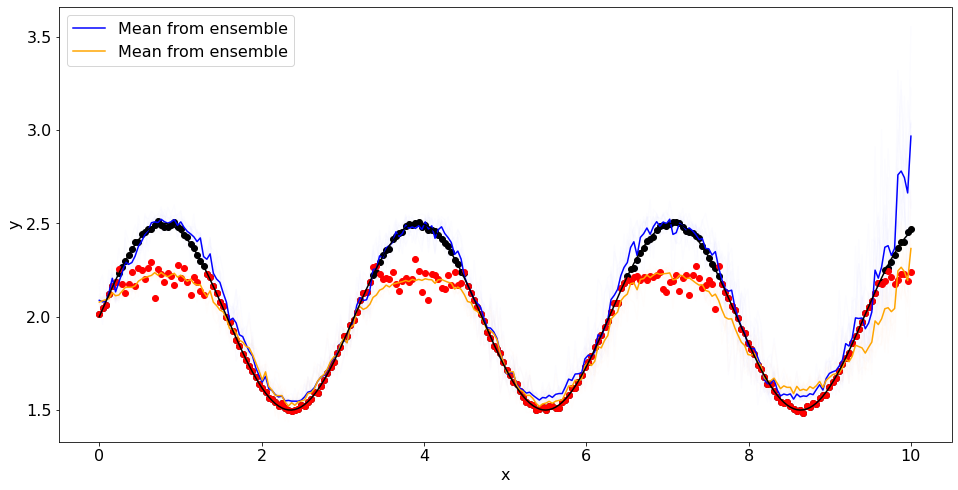

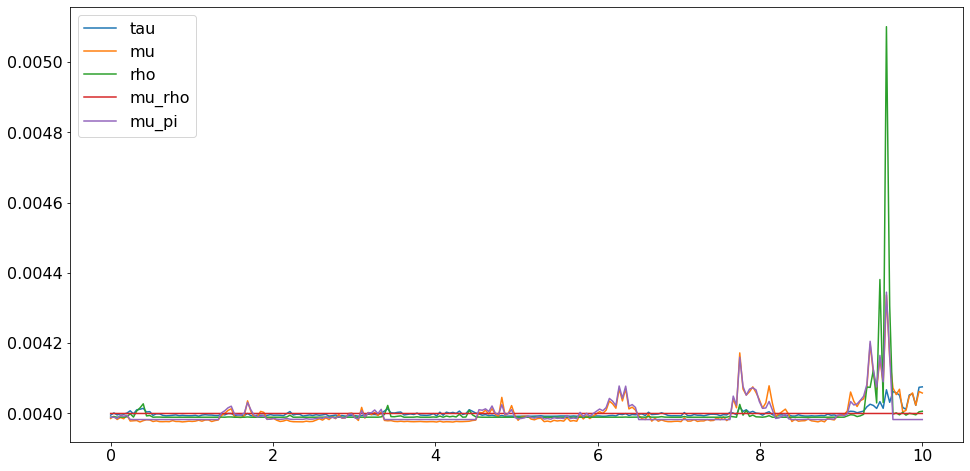

: 

In [ ]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 16})
for i in range(ensemble_size):
    plt.plot(x_, cens_preds[i], color='blue',alpha=0.01)
    plt.plot(x_, uncens_preds[i], color='orange',alpha=0.01)

plt.plot(x_,np.mean(cens_preds, axis=0), label='Mean from ensemble', color='blue')
plt.plot(x_,np.mean(uncens_preds, axis=0), label='Mean from ensemble', color='orange')
#plt.plot(x_, cens, label = 'cens')
#plt.plot(x_,uncens, label='unces')
#plt.plot(x,np.mean(preds, axis=0)-np.std(preds, axis=0))
#plt.plot(x, y_hat)
plt.plot(x, y_true, color='black')
plt.scatter(x, y_obs, color='black')
plt.scatter(x, y_cens, color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
#plt.plot(x_, 1+np.mean(cens_preds > uncens_preds, axis = 0))

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 16})
scores =  tau(cens_preds,uncens_preds, t=censoring,  pt=pt, temperature=1.0)
scores = np.exp(scores)
p = scores /scores.sum()
plt.plot(x_, p, label='tau')
#plt.plot(x_, mu(cens_preds, uncens_preds,t=censoring,  pt=pt, temperature=1.0), label='mu')
scores =  mu(cens_preds,uncens_preds, t=censoring,  pt=pt, temperature=1.0)
scores = np.exp(scores)
p = scores /scores.sum()
plt.plot(x_, p, label='mu')
#plt.plot(x_, rho(cens_preds, uncens_preds,t=censoring,  pt=pt, temperature=1.0), label='rho')
scores =  rho(cens_preds,uncens_preds, t=censoring,  pt=pt, temperature=0.25)
scores = np.exp(scores)
p = scores /scores.sum()
plt.plot(x_, p, label='rho')
#plt.plot(x_, mu_rho(cens_preds, uncens_preds,t=censoring,  pt=pt, temperature=1.0), label='mu_rho')
scores =  mu_rho(cens_preds,uncens_preds, t=censoring,  pt=pt, temperature=0.25)
scores = np.exp(scores)
p = scores /scores.sum()
plt.plot(x_, p, label='mu_rho')
#plt.plot(x_, pi(cens_preds, uncens_preds,t=censoring,  pt=pt, temperature=1.0), label='pi')
scores =  pi(cens_preds,uncens_preds, t=censoring,  pt=pt, temperature=1.0)
scores = np.exp(scores)
p = scores /scores.sum()
#plt.plot(x_, p, label='pi')
#plt.plot(x_, mu_pi(cens_preds, uncens_preds,t=censoring,  pt=pt, temperature=1.0), label='mu_pi')
scores =  mu_pi(cens_preds,uncens_preds, t=censoring,  pt=pt, temperature=1.0)
scores = np.exp(scores)
p = scores /scores.sum()
plt.plot(x_, p, label='mu_pi')
plt.legend()
#plt.ylim(-0.005,0.01)
plt.show()


In [ ]:
pt =  np.mean(cens_preds >= uncens_preds, axis = 0)

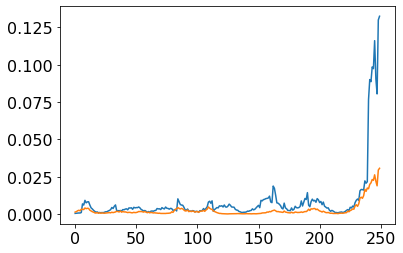

In [ ]:
plt.plot(mu(uncens_preds,cens_preds, t=censoring,  pt=pt, temperature=1.0))
plt.plot(tau(uncens_preds,cens_preds, t=censoring,  pt=pt, temperature=1.0))

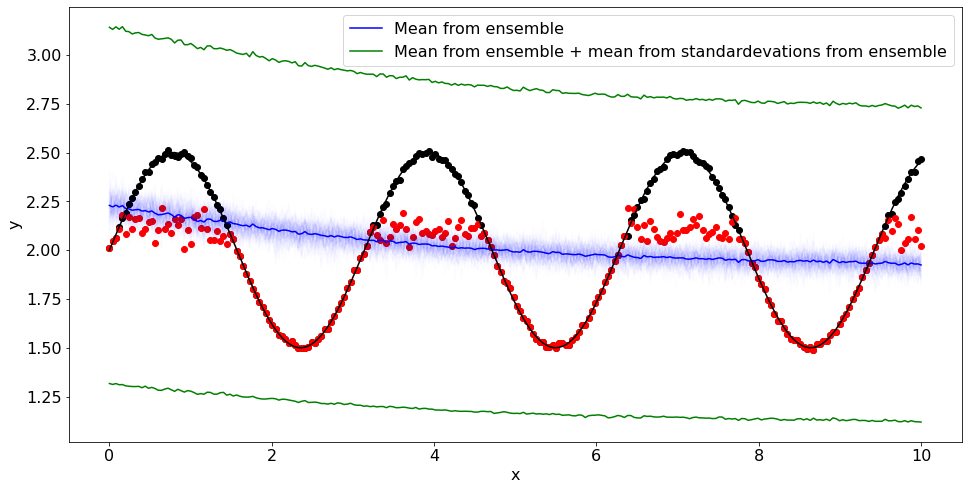

In [ ]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 16})
for i in range(ensemble_size):
    plt.plot(x_, preds[i], color='blue',alpha=0.01)
plt.plot(x_,np.mean(preds, axis=0), label='Mean from ensemble', color='blue')
plt.plot(x_,np.mean(preds, axis=0)+2*np.mean(stds, axis=0), color='green')
plt.plot(x_,np.mean(preds, axis=0)-2*np.mean(stds, axis=0),label='Mean from ensemble + mean from standardevations from ensemble', color='green')

#plt.plot(x,np.mean(preds, axis=0)+np.std(preds, axis=0))

#plt.plot(x,np.mean(preds, axis=0)-np.std(preds, axis=0))
#plt.plot(x, y_hat)
plt.plot(x, y_true, color='black')
plt.scatter(x, y_obs, color='black')
plt.scatter(x, y_cens, color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
#plt.scatter(x, model(x), color='red')
#plt.plot(x,censoring+1)

In [ ]:
from scipy import stats

_eps = 1e-7

tau = preds
gammas = np.clip(stats.norm().cdf(-np.abs(tau) / np.sqrt(2)), _eps, 1 - _eps)
gamma = gammas.mean(0)
predictive_entropy = stats.bernoulli(gamma).entropy()
conditional_entropy = stats.bernoulli(gammas).entropy().mean(0)
# it can get negative very small number because of numerical instabilities
mi = predictive_entropy - conditional_entropy
scores = mi

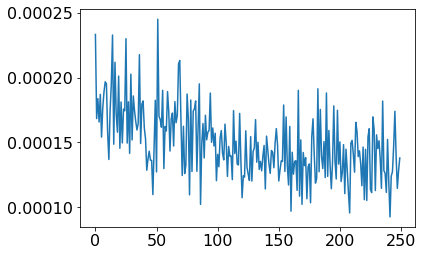

: 

In [ ]:
plt.plot(mi)

In [ ]:
scores = np.exp(scores)
p = scores / scores.sum()
idx = np.random.choice(
    range(len(p)), replace=False, p=p.squeeze(), size=5,
)

In [ ]:
idx

array([185,  74, 189,  56,   1])

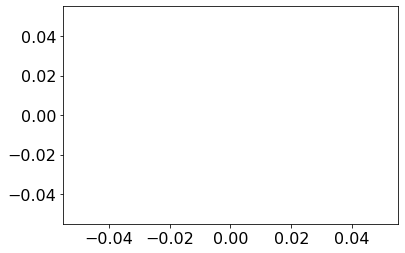

In [ ]:
plt.plot(p.squeeze())

In [ ]:
mean_stddev_all = tf.reduce_mean(stds, axis = 0)
entropy_expected = tf.math.log(mean_stddev_all)
expected_entropy = tf.reduce_mean(tf.math.log(stds), axis=0)
bald = entropy_expected - expected_entropy

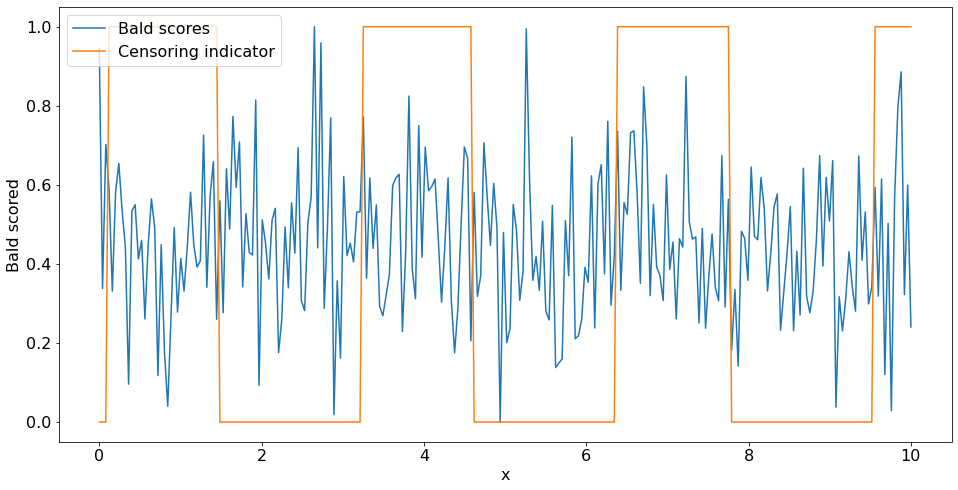

In [ ]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 16})
plt.plot(x_, (bald-np.min(bald))/(np.max(bald)-np.min(bald)), label = 'Bald scores')
#plt.plot(x, bald)
plt.xlabel("x")
plt.plot(x, censoring, label='Censoring indicator')
plt.ylabel("Bald scored")
plt.legend(loc='upper left')
#plt.plot(x, y_true, color='black')
#plt.scatter(x, y_obs, color='black')
#plt.scatter(x, y_cens, color='red')

In [ ]:
tfp.distributions.JointDistribution()

TypeError: Can't instantiate abstract class JointDistribution with abstract methods _flat_sample_distributions, _model_flatten, _model_unflatten

In [ ]:
model(x_)

<tfp.distributions.Normal 'sequential_distribution_lambda_Normal' batch_shape=[250, 1] event_shape=[] dtype=float32>

In [ ]:
tfd = tfp.distributions

In [ ]:
preds = model(x)

In [ ]:
preds.batch_shape[0]

250

In [ ]:
dist = []
for i in range(preds.batch_shape[0]):
    dist.append(model(x[0][:,np.newaxis]))

In [ ]:
tmp = []
for i in range(preds.batch_shape[0]):
    tmp.append(dist[0].cross_entropy(dist[i])[0])

In [ ]:
dist[0].entropy()+dist[1].entropy()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.9686282]], dtype=float32)>

: 

In [ ]:
tmp = []
for i in range(preds.batch_shape[0]):
    tmp.append(dist[0].cross_entropy(dist[i])[0]-)

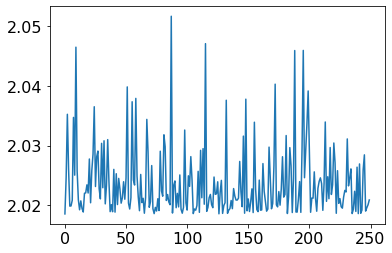

In [ ]:
plt.plot(tmp)

In [ ]:
joint = tfd.JointDistributionSequential(dist[0,1])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
np.array(dist)[[0,1]]

array([<tfp.distributions.Normal 'sequential_distribution_lambda_Normal' batch_shape=[1, 1] event_shape=[] dtype=float32>,
       <tfp.distributions.Normal 'sequential_distribution_lambda_Normal' batch_shape=[1, 1] event_shape=[] dtype=float32>],
      dtype=object)

In [ ]:
joint.cross_entropy()

TypeError: cross_entropy() missing 1 required positional argument: 'other'

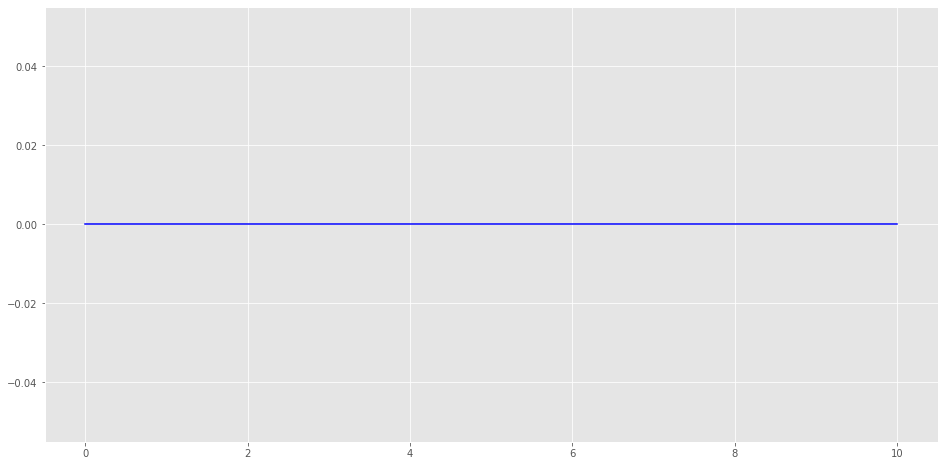

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(x,np.std(preds, axis=0), label='preds', color='blue')

In [ ]:
import tensorflow.keras.backend as K

def create_multi_output_target(y, quantiles):
    y_ = y[:,np.newaxis]
    for _ in range(len(quantiles)-1):
        y_ = np.concatenate((y_, y[:,np.newaxis]), axis=1)
    return y_


def tilted_loss(theta, error):
    return K.maximum(theta*error, (theta-1)*error)

def censored_multi_tilted_loss(quantiles, y, f):
    loss = 0.0
    y = tf.cast(y, tf.float32)
    f = tf.cast(f, tf.float32)
    
    treshold_values = tf.where(y[:,-1] == -1.0, y[:,0], -np.inf)

    for k in range(len(quantiles)):
        q = quantiles[k]
        e = (y[:,k] - K.maximum(treshold_values, f[:,k]))
        loss += tilted_loss(theta=q, error=e)
    return loss


def combined_loss(quantiles, y, f):
    loss = 0.0
    y = tf.cast(y, tf.float32)
    f = tf.cast(f, tf.float32)
    
    treshold_values = tf.where(y[:,-1] == -1.0, y[:,0], -np.inf)

    for k in range(len(quantiles)):
        q = quantiles[k]
        e = (y[:,k] - K.maximum(treshold_values, f[:,k]))
        loss += tilted_loss(theta=q, error=e)

    for k in range(len(quantiles), 2*len(quantiles)):
        q = quantiles[k-len(quantiles)]
        e = (y[:,k] - f[:,k])
        loss += tilted_loss(theta=q, error=e)
    return loss


class MCDropout(Dropout):
    """ A MonteCarlo (MC) dropout layer used for a MC dense network

    """
    def call(self, inputs):
        return super().call(inputs, training=True)

quantiles = [0.05, 0.5, 0.95]
model = Sequential([
    layers.Dense(256, input_shape=(1,), activation='sigmoid'),
    MCDropout(0.05),
    layers.Dense(256, activation='sigmoid'),
    MCDropout(0.05),
    layers.Dense(256, activation='sigmoid'),
    MCDropout(0.05),
    layers.Dense(256, activation='sigmoid'),
    #MCDropout(0.25),
    layers.Dense(len(quantiles))
])

opt= tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1)

In [ ]:
y_train_ = create_multi_output_target(y_cens[:,0], quantiles)
y_train_ = np.concatenate((y_train_, create_multi_output_target(y_cens[:,0], quantiles)), axis=1)
tmp = np.concatenate((y_train_, censoring[:,np.newaxis]), axis=1)

In [ ]:
#model.compile(loss=[lambda y, y_pred: tobit_nll(y, y_pred, train_censoring)],optimizer=opt)
#model.compile(loss=lambda y,f: combined_loss(quantiles, y, f),optimizer=opt)
model.compile(loss=lambda y,f: censored_multi_tilted_loss(quantiles, y, f),optimizer=opt)
     
#[lambda y, rv_y: -rv_y.log_prob(y)]
history = model.fit(x, -1*tmp, epochs = 1000*5, verbose = 2,  shuffle=True)

Epoch 1/5000
8/8 - 1s - loss: 3.4263
Epoch 2/5000
8/8 - 0s - loss: 1.4734
Epoch 3/5000
8/8 - 0s - loss: 0.5982
Epoch 4/5000
8/8 - 0s - loss: 0.2287
Epoch 5/5000
8/8 - 0s - loss: 0.2532
Epoch 6/5000
8/8 - 0s - loss: 0.1871
Epoch 7/5000
8/8 - 0s - loss: 0.1744
Epoch 8/5000
8/8 - 0s - loss: 0.1667
Epoch 9/5000
8/8 - 0s - loss: 0.1483
Epoch 10/5000
8/8 - 0s - loss: 0.1433
Epoch 11/5000
8/8 - 0s - loss: 0.1360
Epoch 12/5000
8/8 - 0s - loss: 0.1432
Epoch 13/5000
8/8 - 0s - loss: 0.1404
Epoch 14/5000
8/8 - 0s - loss: 0.1414
Epoch 15/5000
8/8 - 0s - loss: 0.1391
Epoch 16/5000
8/8 - 0s - loss: 0.1359
Epoch 17/5000
8/8 - 0s - loss: 0.1393
Epoch 18/5000
8/8 - 0s - loss: 0.1386
Epoch 19/5000
8/8 - 0s - loss: 0.1381
Epoch 20/5000
8/8 - 0s - loss: 0.1444
Epoch 21/5000
8/8 - 0s - loss: 0.1426
Epoch 22/5000
8/8 - 0s - loss: 0.1389
Epoch 23/5000
8/8 - 0s - loss: 0.1444
Epoch 24/5000
8/8 - 0s - loss: 0.1398
Epoch 25/5000
8/8 - 0s - loss: 0.1419
Epoch 26/5000
8/8 - 0s - loss: 0.1347
Epoch 27/5000
8/8 - 0

KeyboardInterrupt: 

In [ ]:
ensemble_size = 1000
x_ = np.linspace(0,10,100).reshape(100,1)
#preds = np.zeros([ensemble_size, x.shape[0]])
#preds_05 = np.zeros([ensemble_size, x.shape[0]])
#preds_95 = np.zeros([ensemble_size, x.shape[0]])
#means = np.zeros([ensemble_size, x.shape[0]])
preds = np.zeros([ensemble_size, 100])
preds_05 = np.zeros([ensemble_size, 100])
preds_95 = np.zeros([ensemble_size, 100])
#means = np.zeros([ensemble_size, 100])
#q05 = np.zeros([ensemble_size, 100])
#q95 = np.zeros([ensemble_size, 100])
for i in range(ensemble_size):
    _ = -1*model(x_) 
    preds[i] = _[:,1]
    preds_05[i] = _[:,2]
    preds_95[i] = _[:,0]
    #means[i] = _[:,4]
    #q05[i] = _[:,3]
    #q95[i] = _[:,5]


InvalidArgumentError: slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

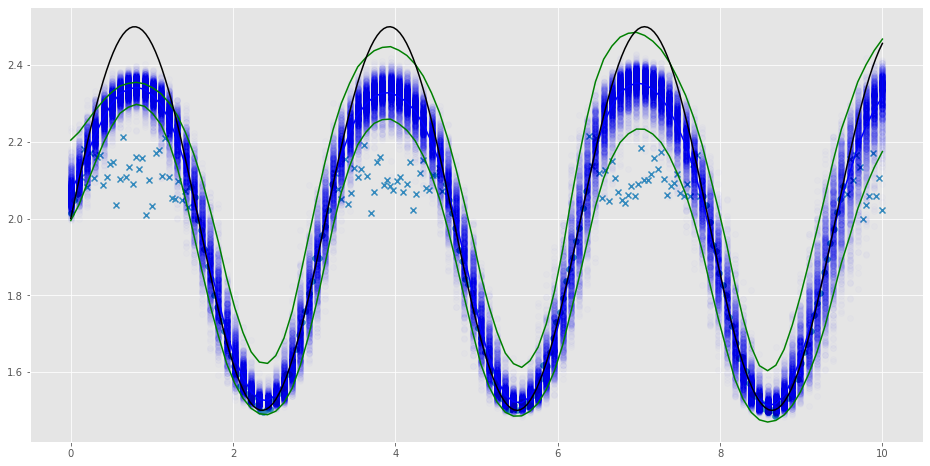

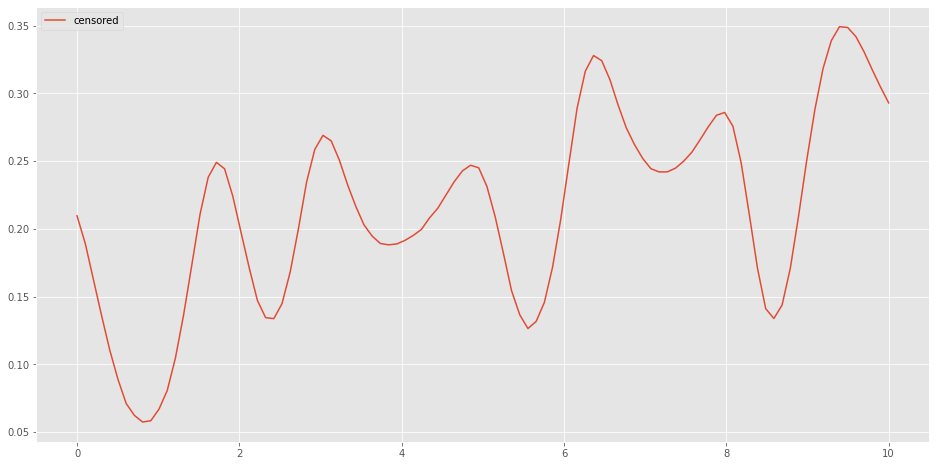

/home/fbohy/censored_active_learning/AL/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/home/fbohy/censored_active_learning/AL/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract


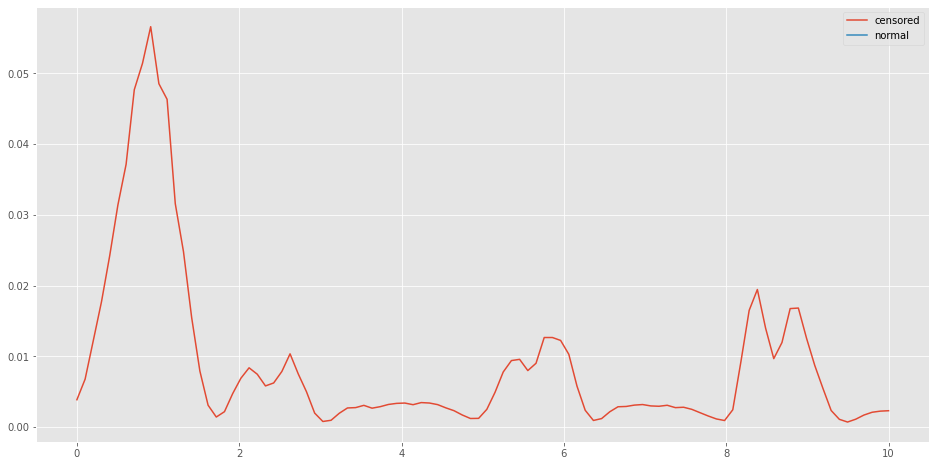

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(16,8))
for i in range(ensemble_size):
    plt.plot(x_, preds[i],'o', color='blue',alpha=0.01)
    #plt.plot(x_, means[i],'o',color='orange',alpha=0.01)
    #plt.plot(x, preds_05[i], color='green',alpha=0.1)
    #plt.plot(x, preds_95[i], color='green',alpha=0.1)
plt.plot(x_,np.mean(preds, axis=0), label='preds', color='blue')
#plt.plot(x_,np.quantile(preds,0.05, axis=0), label='preds', color='blue')
#plt.plot(x_,np.quantile(preds, 0.95, axis=0), label='preds', color='blue')
plt.plot(x_,np.mean(preds_05, axis=0), label='preds', color='green')
plt.plot(x_,np.mean(preds_95, axis=0), label='preds', color='green')
#plt.plot(x_,np.mean(means, axis=0), label='preds', color='orange')
#plt.plot(x_,np.quantile(means, 0.95, axis=0), label='preds', color='orange')
#plt.plot(x_,np.quantile(means, 0.05, axis=0), label='preds', color='orange')
#plt.plot(x_,np.mean(q05, axis=0), label='preds', color='red')
#plt.plot(x_,np.mean(q95, axis=0), label='preds', color='red')
#plt.plot(x,np.mean(preds, axis=0)+2*np.mean(stds, axis=0), color='green')
#plt.plot(x,np.mean(preds, axis=0)-2*np.mean(stds, axis=0), color='green')

#plt.plot(x,np.mean(preds, axis=0)+np.std(preds, axis=0))

#plt.plot(x,np.mean(preds, axis=0)-np.std(preds, axis=0))
#plt.plot(x, y_hat) 
plt.plot(x, y_true, color='black', label='True function')
#plt.scatter(x, y_obs, color='black')
#plt.scatter(x, y_cens, color='red', label='observations')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');
plt.show()
plt.figure(figsize=(16,8))
plt.plot(x_,np.mean(preds_95-preds_05, axis = 0), label='censored')
plt.legend()
plt.show()
plt.figure(figsize=(16,8))
plt.plot(x_,np.log(np.mean(preds_95,axis=0)-np.mean(preds_05,axis=0))-np.mean(np.log(abs(preds_95-preds_05)), axis = 0), label='censored')
plt.plot(x_,np.log(np.mean(q05,axis=0)-np.mean(q95,axis=0))-np.mean(np.log(abs(q95-q05)), axis = 0), label='normal')
plt.legend()
plt.show()
#plt.ylim(0,5)

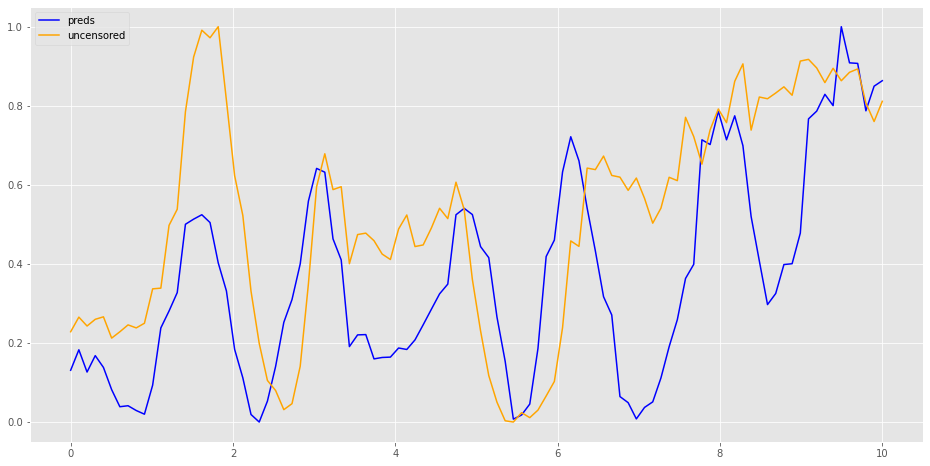

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(x_,(np.std(preds, axis=0)-np.min((np.std(preds, axis=0))))/(np.max((np.std(preds, axis=0)))-np.min((np.std(preds, axis=0)))), label='preds', color='blue')
#plt.plot(x_,(np.std(preds_05, axis=0)-np.min((np.std(preds_05, axis=0))))/(np.max((np.std(preds_05, axis=0)))-np.min((np.std(preds_05, axis=0)))), label='q05', color='green')
#plt.plot(x_,(np.std(preds_95, axis=0)-np.min((np.std(preds_95, axis=0))))/(np.max((np.std(preds_95, axis=0)))-np.min((np.std(preds_95, axis=0)))), label='q95', color='red')

#plt.plot(x_,(np.std(means, axis=0)-np.min((np.std(means, axis=0))))/(np.max((np.std(means, axis=0)))-np.min((np.std(means, axis=0)))), label='uncensored', color='orange')
plt.legend()
#plt.plot(x,np.std(preds_05, axis=0), label='preds', color='green')
#plt.plot(x,np.std(preds_95, axis=0), label='preds', color='red')
#plt.plot(x, censoring)

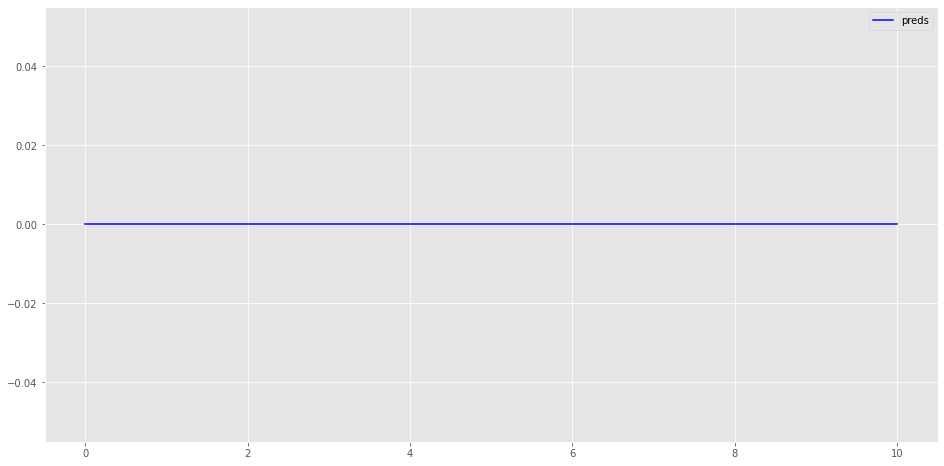

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(x_,abs((np.mean(means,axis=0)-np.mean(preds, axis=0))), label='preds', color='blue')
#plt.plot(x_,abs(np.mean(np.log(means)-np.log(preds), axis=0)), label='preds', color='red')
#plt.plot(x,(np.std(preds_05, axis=0)-np.min((np.std(preds_05, axis=0))))/(np.max((np.std(preds_05, axis=0)))-np.min((np.std(preds_05, axis=0)))), label='q05', color='green')
#plt.plot(x,(np.std(preds_95, axis=0)-np.min((np.std(preds_95, axis=0))))/(np.max((np.std(preds_95, axis=0)))-np.min((np.std(preds_95, axis=0)))), label='q95', color='red')
plt.legend()
#plt.plot(x,np.std(preds_05, axis=0), label='preds', color='green')
#plt.plot(x,np.std(preds_95, axis=0), label='preds', color='red')
#plt.plot(x, censoring)

/home/fbohy/censored_active_learning/AL/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


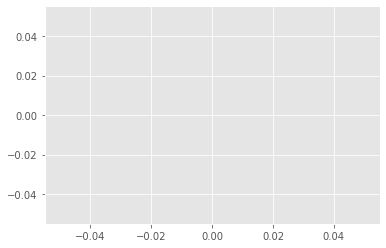

In [ ]:
plt.plot(np.log(np.std(preds-means, axis=0)))
#plt.plot(np.std(np.log((preds-means)), axis=0))

In [ ]:
sigma1_ = (preds_95-preds_05)
sigma2_ = (q05-q95)

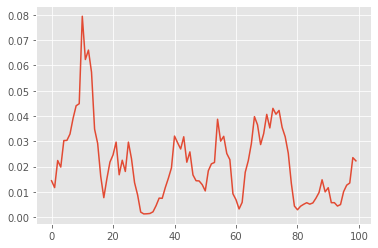

In [ ]:
plt.plot(np.log(np.mean(sigma1_, axis=0))-(np.mean(np.log(sigma1_), axis=0)))

In [ ]:
np.linalg.det(np.cov(sigma1_[:,17], sigma1_[:,17]))

9.838462919023878e-22

In [ ]:
sel = sigma1_[:,17][:,np.newaxis]

In [ ]:
sigma1_.shape

(100, 100)

In [ ]:
sel = np.concatenate((sel, sigma1_[:,74][:,np.newaxis]), axis=1)

In [ ]:
covariance = []
for i in range(0,100):
    if i == 17:
        covariance.append(None)
    else:        
        covariance.append(np.log(np.linalg.det(np.cov(np.concatenate((sel, sigma1_[:,i][:,np.newaxis]), axis=1).T)))-np.mean(sel))

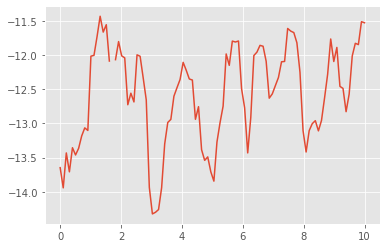

In [ ]:
plt.plot(x_, covariance)

In [ ]:
np.mean(sel)

0.40070091128349306

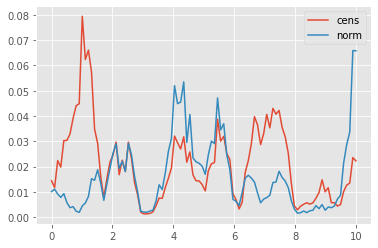

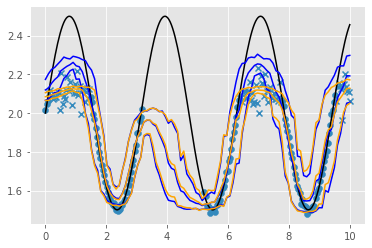

In [ ]:
plt.plot(x_,np.log(np.mean(sigma1_, axis=0))-np.mean(np.log(sigma1_), axis=0),label='cens')
plt.plot(x_,np.log(np.mean(sigma2_, axis=0))-np.mean(np.log(sigma2_), axis=0), label='norm')
plt.legend()
plt.show()
plt.plot(x_true, y_true, color='black', label='True function')
#plt.scatter(x, y_obs, color='black')
#plt.scatter(x, y_cens, color='red', label='observations')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');
plt.plot(x_,np.mean(preds, axis=0), label='preds', color='blue')
plt.plot(x_,np.quantile(preds,0.05, axis=0), label='preds', color='blue')
plt.plot(x_,np.quantile(preds, 0.95, axis=0), label='preds', color='blue')
#plt.plot(x_,np.mean(preds_05, axis=0), label='preds', color='green')
#plt.plot(x_,np.mean(preds_95, axis=0), label='preds', color='green')
plt.plot(x_,np.mean(means, axis=0), label='preds', color='orange')
plt.plot(x_,np.quantile(means, 0.95, axis=0), label='preds', color='orange')
plt.plot(x_,np.quantile(means, 0.05, axis=0), label='preds', color='orange')

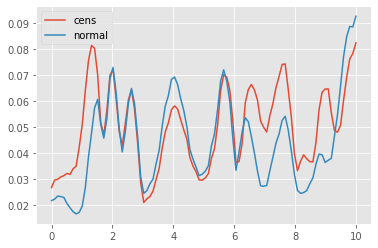

In [ ]:
plt.plot(x_, np.mean(sigma1_, axis=0), label='cens')
plt.plot(x_, np.mean(sigma2_, axis=0), label='normal')
plt.legend()

In [ ]:
ensemble_size = 1000
_preds = np.zeros([ensemble_size, x.shape[0]])
_preds_05 = np.zeros([ensemble_size, x.shape[0]])
_preds_95 = np.zeros([ensemble_size, x.shape[0]])
for i in range(ensemble_size):
    _ = -1*model(x)
    _preds[i] = _[:,1]
    _preds_05[i] = _[:,2]
    _preds_95[i] = _[:,0]

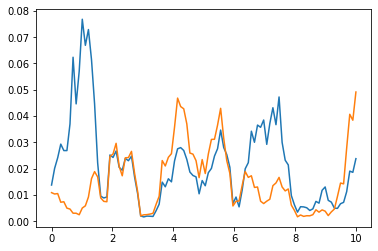

In [ ]:
plt.plot(x_,np.log(np.mean(preds_95,axis=0)-np.mean(preds_05,axis=0))-np.mean(np.log(abs(preds_95-preds_05)), axis = 0), label='normal')
plt.plot(x_,np.log(np.mean(q05,axis=0)-np.mean(q95,axis=0))-np.mean(np.log(abs(q95-q05)), axis = 0), label='normal')
#plt.ylim(-0.1,0.3)
#plt.plot(x_,np.mean(np.log(abs(preds_95-preds_05)), axis = 0))
#plt.plot(x_,np.log(np.mean(means,axis=0)-np.mean(preds_05,axis=0)))
#plt.plot(x_,np.mean(np.log(abs(preds_95-preds_95)), axis = 0))
#plt.plot(x, 0.01*x)

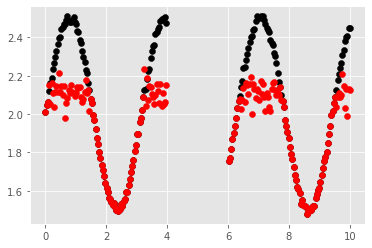

ValueError: 'c' argument has 200 elements, which is inconsistent with 'x' and 'y' with size 100.

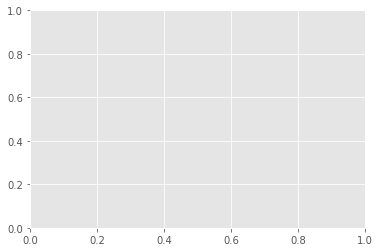

In [ ]:
plt.style.use('ggplot')
plt.scatter(x, y_obs, color='black')
plt.scatter(x, y_cens, color='red')
plt.show()
plt.style.use('ggplot')
plt.scatter(x_,(np.mean(abs(preds_95),axis=0)-np.mean(abs(preds_05),axis=0)) - (np.mean(abs(preds_95-preds_05), axis = 0)), c=censoring, alpha=0.5)
plt.show()
plt.style.use('ggplot')
plt.plot(x,censoring)
plt.show()

In [ ]:
np.mean(preds_05)

1.8333798884809016

In [ ]:
import h5py    
import matplotlib.pyplot as plt
import numpy as np    
f1 = h5py.File("data/gbsg_cancer_train_test.h5",'r+')   
f1 = h5py.File("data/metabric_IHC4_clinical_train_test.h5",'r+')   

In [ ]:
train = f1['train']['x']
etrain = f1['train']['e']
ttrain = f1['train']['t']

In [ ]:
test = f1['test']['x']
etest = f1['test']['e']
ttest = f1['test']['t']

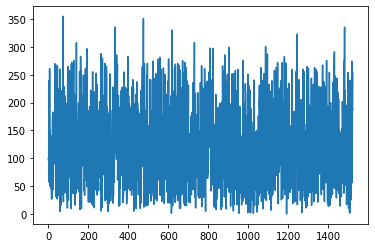

In [ ]:
plt.plot(ttrain)
#plt.plot(ttest)

In [ ]:
#plt.plot(etrain)
#plt.plot(etest)

In [ ]:
sum(etrain)

887

In [ ]:
sum(etest)

216

In [ ]:
print(train[:5])

[[ 5.603834   7.8113923 10.797988   5.9676075  1.         1.
   0.         1.        56.84     ]
 [ 5.2848816  9.581043  10.20462    5.6649704  1.         0.
   0.         1.        85.94     ]
 [ 5.920251   6.776564  12.431715   5.8738575  0.         1.
   0.         1.        48.44     ]
 [ 6.654017   5.3418455  8.6463785  5.655888   0.         0.
   0.         0.        66.91     ]
 [ 5.456747   5.339741  10.555724   6.008429   1.         0.
   0.         1.        67.85     ]]


In [ ]:
f1['train']['x'][()].shape

(1523, 9)

In [ ]:
f1['train']['e'][()]

array([0, 1, 0, ..., 0, 1, 1], dtype=int32)

In [ ]:
filename = "data/gbsg_cancer_train_test.h5"

In [ ]:

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['test', 'train']>
<class 'h5py._hl.group.Group'>


AttributeError: 'tuple' object has no attribute 'encode'

In [ ]:
import numpy as np
from numpy.random import RandomState


def generate_synthetic_data(verbose, betas, seed, epsilon, size):
    prng = RandomState(seed=seed)
    x0 = np.ones(size)
    x1 = np.power(-1, prng.binomial(n=1, p=0.5, size=size))
    x2 = prng.normal(size=size)
    X = np.concatenate([x0, x1, x2]).reshape(3, size)
    noise = epsilon(X=X, prng=prng, size=size)
    y_star = np.dot(np.array(betas), X) + noise
    y = np.clip(y_star, a_min=0, a_max=None)
    if verbose:
        print('Censored observations: %d of %d (%.2f%%)' % (sum(y == 0), size, sum(y == 0) / size))
    return {'x0': x0, 'x1': x1, 'x2': x2, 'noise': noise, 'X': X, 'y': y, 'y_star': y_star}

In [ ]:
import numpy as np
from scipy.stats import norm
def make_ds1(verbose, num_samples, seed):
    return generate_synthetic_data(
        verbose=verbose,
        size=num_samples,
        betas=(1, 1, 1), 
        seed=seed, 
        epsilon=epsilon_ds1)


def epsilon_ds1(X, prng, size):
    return prng.normal(size=size)
        

def ppf_ystar_ds1(ds, theta):
    return norm(loc=ds['x0'] + ds['x1'] + ds['x2'],
                scale=1)\
        .ppf(theta)


def ppf_censored_y_ds1(ds, theta):
    return np.maximum(0, ppf_ystar_ds1(ds, theta))

def make_ds2(verbose, num_samples, seed):
    return generate_synthetic_data(
        verbose=verbose,
        size=num_samples, 
        betas=(1, 1, 1), 
        seed=seed, 
        epsilon=epsilon_ds2)


def epsilon_ds2(X, prng, size):
    return np.multiply((1 + X[2, :]), prng.normal(size=size))


def ppf_ystar_ds2(ds, theta):
    return norm(loc=ds['x0'] + ds['x1'] + ds['x2'], 
                scale=abs(1 + ds['x2']))\
        .ppf(theta)


def ppf_censored_y_ds2(ds, theta):
    return np.maximum(0, ppf_ystar_ds2(ds, theta))


def make_ds3(verbose, num_samples, seed):
    return generate_synthetic_data(
        verbose=verbose,
        size=num_samples, 
        betas=(1, 1, 1), 
        seed=seed, 
        epsilon=epsilon_ds3)


def epsilon_ds3(X, prng, size):
    return (0.75 * prng.normal(size=size)) + (0.25 * prng.normal(size=size, scale=2))


def ppf_ystar_ds3(ds, theta):
    return norm(loc=ds['x0'] + ds['x1'] + ds['x2'], 
                scale=((0.75 ** 2) + (0.25 ** 2)) ** 0.5)\
        .ppf(theta)


def ppf_censored_y_ds3(ds, theta):
    return np.maximum(0, ppf_ystar_ds3(ds, theta))

In [ ]:
ds1 = make_ds3(True, 500, 25)

Censored observations: 133 of 500 (0.27%)


In [ ]:
ds1.keys()

dict_keys(['x0', 'x1', 'x2', 'noise', 'X', 'y', 'y_star'])

In [ ]:
ds1['X'].T.shape[-1]

3

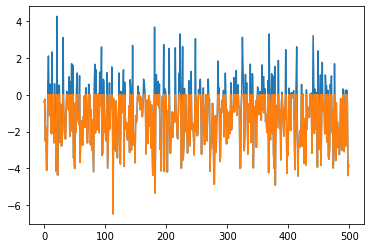

In [ ]:
plt.plot(-1*ds1['y_star'])
plt.plot(-1*ds1['y'])

In [ ]:
-1*ds1['y_star'] > -1*ds1['y'])+0

133